In [13]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap
import matplotlib.pyplot as plt

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# ---- (A) Load MBTA GTFS ----
stops = pd.read_csv("drive/MyDrive/MBTA_GTFS/stops.txt")
stop_times = pd.read_csv("drive/MyDrive/MBTA_GTFS/stop_times.txt")
trips = pd.read_csv("drive/MyDrive/MBTA_GTFS/trips.txt")

# Convert stops to GeoDataFrame
stops_gdf = gpd.GeoDataFrame(
    stops,
    geometry=gpd.points_from_xy(stops.stop_lon, stops.stop_lat),
    crs="EPSG:4326"
)


/tmp/ipython-input-3237693766.py:3: DtypeWarning: Columns (0,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  stop_times = pd.read_csv("drive/MyDrive/MBTA_GTFS/stop_times.txt")


In [16]:

# ---- (B) Load Census Tracts Shapefile ----
tracts = gpd.read_file("drive/MyDrive/tl_2024_25_tract/tl_2024_25_tract.shp")
# Filter Massachusetts (FIPS = 25)
tracts = tracts[tracts["STATEFP"] == "25"]
boston_tracts = tracts[tracts["COUNTYFP"] == "025"].copy()
boston_tracts = boston_tracts[["GEOID", "geometry"]]



In [17]:
# Ensure CRS match
stops_gdf = stops_gdf.to_crs(boston_tracts.crs)
stops_boston = gpd.sjoin(stops_gdf, boston_tracts, how="inner", predicate="within")

In [18]:
# ---- (C) Load Race Demographics (ACS B03002 Data.csv) ----
race = pd.read_csv("drive/MyDrive/B03002/Data.csv")

# Clean GEOID (remove "1400000US" prefix)
race["GEOID"] = race["GEO_ID"].str.replace("1400000US", "", regex=False)

# Keep relevant columns
race = race[[
    "GEOID",
    "B03002_001E",  # total population
    "B03002_003E",  # White alone
    "B03002_004E",  # Black alone
    "B03002_006E",  # Asian alone
    "B03002_012E",  # Hispanic/Latino
]]





In [19]:
print("Number of rows in race:", len(race))
print("Unique GEOIDs:", race['GEOID'].nunique())
print(race[['GEOID', 'B03002_001E', 'B03002_003E', 'B03002_004E', 'B03002_006E', 'B03002_012E']].head(10))  # Check first 10 rows
print(race[['B03002_001E', 'B03002_003E', 'B03002_004E', 'B03002_006E', 'B03002_012E']].describe())  # Should show varying mins/maxes/std if correct
print("Unique total populations:", race['B03002_001E'].nunique())  # Should be >1 if tract-level

Number of rows in race: 1621
Unique GEOIDs: 1621
         GEOID       B03002_001E  \
0    Geography  Estimate!!Total:   
1  25001010100              3681   
2  25001010206              4371   
3  25001010208              1675   
4  25001010304              2745   
5  25001010306              3027   
6  25001010400              3335   
7  25001010500              3007   
8  25001010600              3380   
9  25001010700              3263   

                                         B03002_003E  \
0  Estimate!!Total:!!Not Hispanic or Latino:!!Whi...   
1                                               2747   
2                                               3894   
3                                               1674   
4                                               2558   
5                                               2552   
6                                               3230   
7                                               2908   
8                                               31

In [20]:
# ===================================================
# 2. SPATIAL JOIN: Assign each MBTA stop to a census tract
# ===================================================

# Merge race onto tract shapes
boston_tracts = boston_tracts.merge(race, on="GEOID", how="left")
boston_tracts = boston_tracts.to_crs("EPSG:4326")  # ensure same CRS


race_cols = [
    "B03002_001E",  # Total population
    "B03002_003E",  # White alone
    "B03002_004E",  # Black alone
    "B03002_006E",  # Asian alone
    "B03002_012E",  # Hispanic
]

for col in race_cols:
    boston_tracts[col] = pd.to_numeric(boston_tracts[col], errors="coerce")


if "index_right" in stops_boston.columns:
    stops_boston = stops_boston.drop(columns="index_right")

if "index_right" in boston_tracts.columns:
    boston_tracts = boston_tracts.drop(columns="index_right")


stops_with_tract = gpd.sjoin(
    stops_boston,
    boston_tracts,
    how="left",
    predicate="within"
)


# Convert B03002 columns to numeric
race_cols = [
    "B03002_001E",  # Total population
    "B03002_003E",  # White alone
    "B03002_004E",  # Black alone
    "B03002_006E",  # Asian alone
    "B03002_012E",  # Hispanic
]

for col in race_cols:
    stops_with_tract[col] = pd.to_numeric(stops_with_tract[col], errors="coerce")



/tmp/ipython-input-947785563.py:29: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: EPSG:4326

  stops_with_tract = gpd.sjoin(


In [21]:
# ===================================================
# 3. ASSIGN ROUTE DEMOGRAPHICS (aggregate stops → route)
# ===================================================

# join stop_times → stops_with_tract → trips
df = stop_times.merge(stops_with_tract, on="stop_id")
df = df.merge(trips[["trip_id", "route_id"]], on="trip_id")

# aggregate demographics for each route
route_demo = df.groupby("route_id").agg({
    "B03002_001E": "mean",
    "B03002_003E": "mean",
    "B03002_004E": "mean",
    "B03002_006E": "mean",
    "B03002_012E": "mean",
}).reset_index()

# compute race percentages (optional but recommended)
route_demo["pct_white"] = route_demo["B03002_003E"] / route_demo["B03002_001E"]
route_demo["pct_black"] = route_demo["B03002_004E"] / route_demo["B03002_001E"]
route_demo["pct_asian"] = route_demo["B03002_006E"] / route_demo["B03002_001E"]
route_demo["pct_hispanic"] = route_demo["B03002_012E"] / route_demo["B03002_001E"]

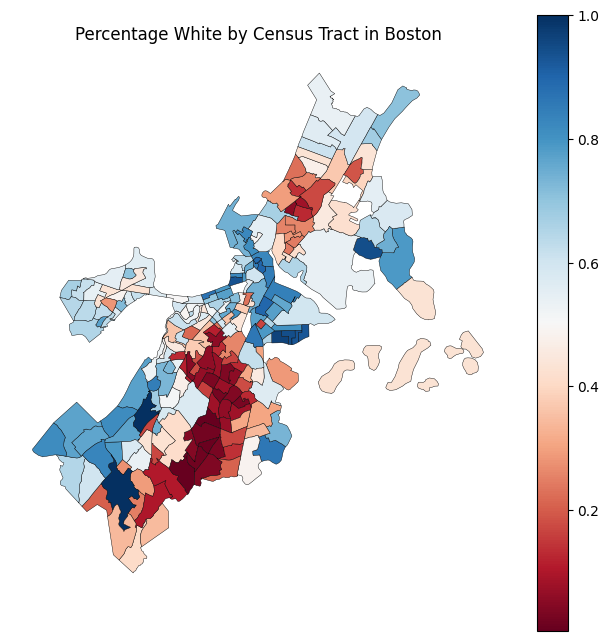

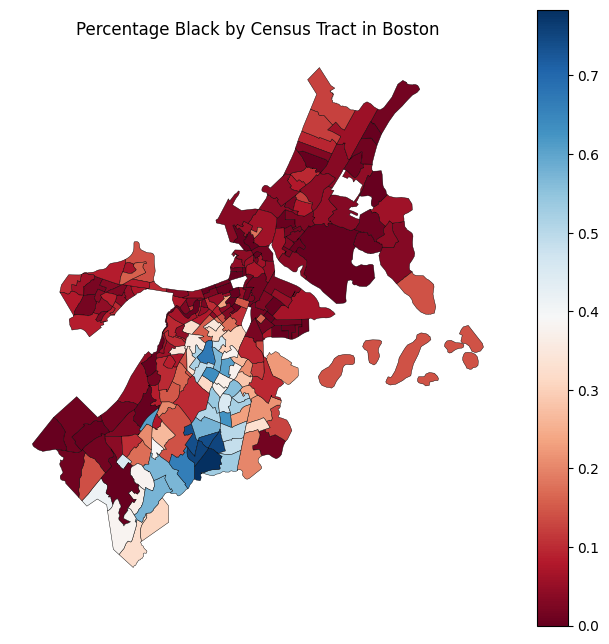

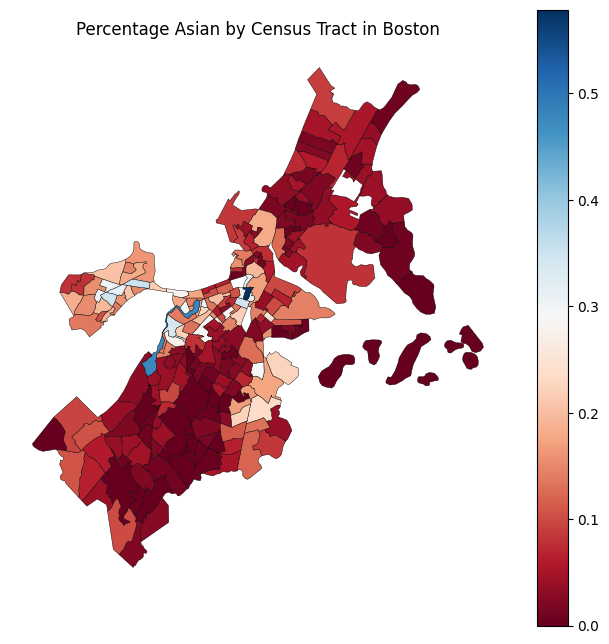

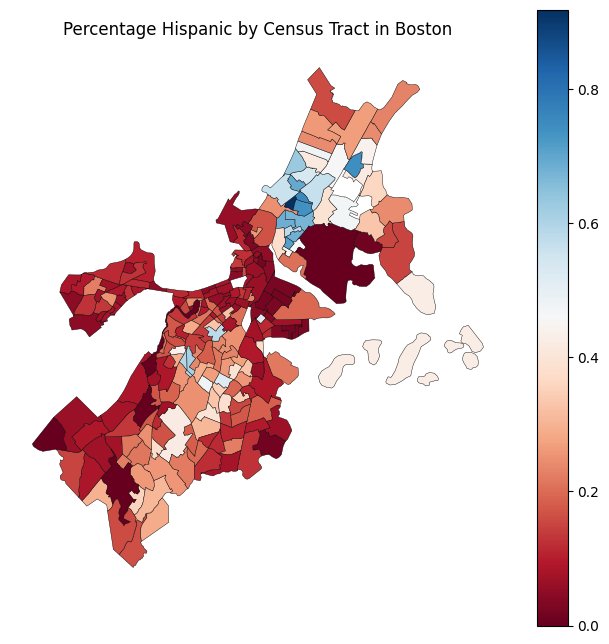

In [22]:
import matplotlib.pyplot as plt

# Define race percentage columns and labels
race_pct_cols = {
    "pct_white": "White",
    "pct_black": "Black",
    "pct_asian": "Asian",
    "pct_hispanic": "Hispanic"
}

# Compute percentages if not already done
boston_tracts["pct_white"] = boston_tracts["B03002_003E"] / boston_tracts["B03002_001E"]
boston_tracts["pct_black"] = boston_tracts["B03002_004E"] / boston_tracts["B03002_001E"]
boston_tracts["pct_asian"] = boston_tracts["B03002_006E"] / boston_tracts["B03002_001E"]
boston_tracts["pct_hispanic"] = boston_tracts["B03002_012E"] / boston_tracts["B03002_001E"]

# Plot each race
for col, label in race_pct_cols.items():
    fig, ax = plt.subplots(figsize=(8, 8))
    boston_tracts.plot(
        column=col,
        cmap="RdBu",      # Red → Blue colormap
        legend=True,
        ax=ax,
        edgecolor='black', # optional: outlines tracts
        linewidth=0.3
    )
    # boston_tracts.plot(ax=ax, cmap="RdBu", edgecolor='blue', linewidth=0.5, legend=True,column=col)
    plt.title(f"Percentage {label} by Census Tract in Boston")
    plt.axis("off")  # optional: remove axis
    plt.show()



Plot MBTA Stops and Tracts Together

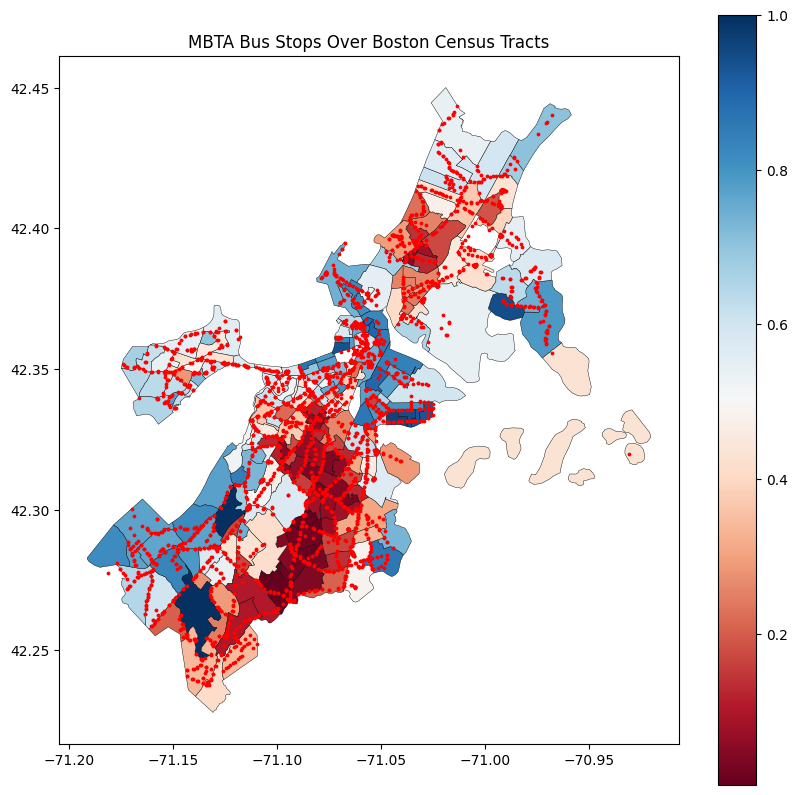

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
boston_tracts.plot(
        column="pct_white",
        cmap="RdBu",      # Red → Blue colormap
        legend=True,
        ax=ax,
        edgecolor='black', # optional: outlines tracts
        linewidth=0.3
    )
# boston_tracts.plot(ax=ax, color='lightgray', edgecolor='blue', linewidth=0.5,cmap="RdBu",column ="pct_white" )  # Plots filled tracts with outlines
stops_boston.plot(ax=ax, color='red', markersize=3)
ax.set_title("MBTA Bus Stops Over Boston Census Tracts")
plt.show()

Check demographic distribution for the stops

In [24]:
stops_with_tract[["B03002_003E","B03002_004E","B03002_006E","B03002_012E"]].describe()


,B03002_003E,B03002_004E,B03002_006E,B03002_012E
count,3374.000000,3374.000000,3374.000000,3374.000000
mean,1720.417309,676.909306,350.882039,851.256372
std,1120.762455,1034.917690,348.391211,863.272457
min,0.000000,0.000000,0.000000,0.000000
25%,979.500000,75.000000,78.000000,239.000000
50%,1572.000000,215.000000,243.000000,529.000000
75%,2595.000000,734.000000,564.000000,1233.000000
max,5097.000000,4992.000000,2394.000000,5654.000000


Visualize Distribution of Race Percentages Across Stops

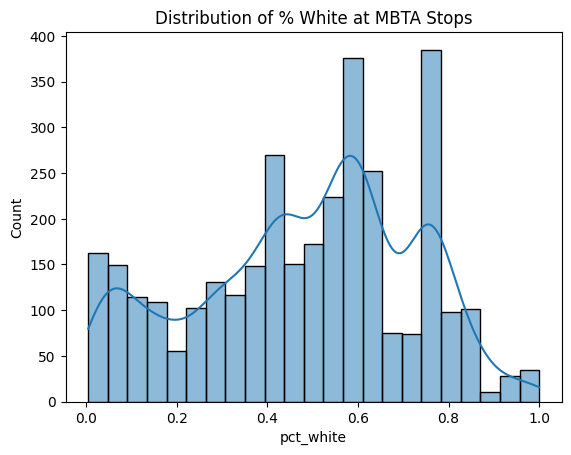

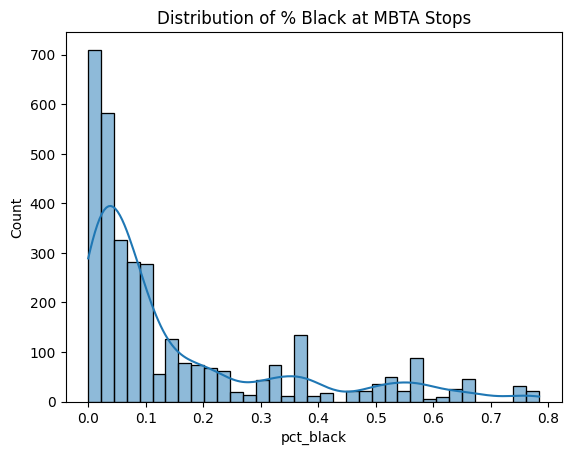

In [25]:
import seaborn as sns

# Ensure B03002 columns are numeric
race_cols = ["B03002_001E","B03002_003E","B03002_004E","B03002_006E","B03002_012E"]

for col in race_cols:
    stops_with_tract[col] = pd.to_numeric(stops_with_tract[col], errors="coerce")

# Compute race percentages
stops_with_tract["pct_white"] = stops_with_tract["B03002_003E"] / stops_with_tract["B03002_001E"]
stops_with_tract["pct_black"] = stops_with_tract["B03002_004E"] / stops_with_tract["B03002_001E"]
stops_with_tract["pct_asian"] = stops_with_tract["B03002_006E"] / stops_with_tract["B03002_001E"]
stops_with_tract["pct_hispanic"] = stops_with_tract["B03002_012E"] / stops_with_tract["B03002_001E"]


sns.histplot(stops_with_tract["pct_white"], kde=True)
plt.title("Distribution of % White at MBTA Stops")
plt.show()

sns.histplot(stops_with_tract["pct_black"], kde=True)
plt.title("Distribution of % Black at MBTA Stops")
plt.show()

Bar Chart of Demographics by Route

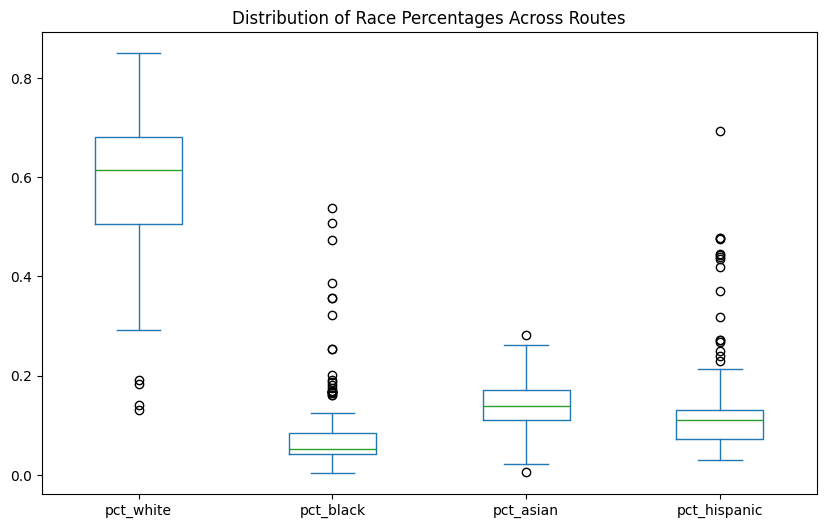

In [26]:
route_demo[["pct_white","pct_black","pct_asian","pct_hispanic"]].plot(
    kind="box",
    figsize=(10,6)
)
plt.title("Distribution of Race Percentages Across Routes")
plt.show()


Scatterplots: Race vs. Headway or Ridership (if available later)

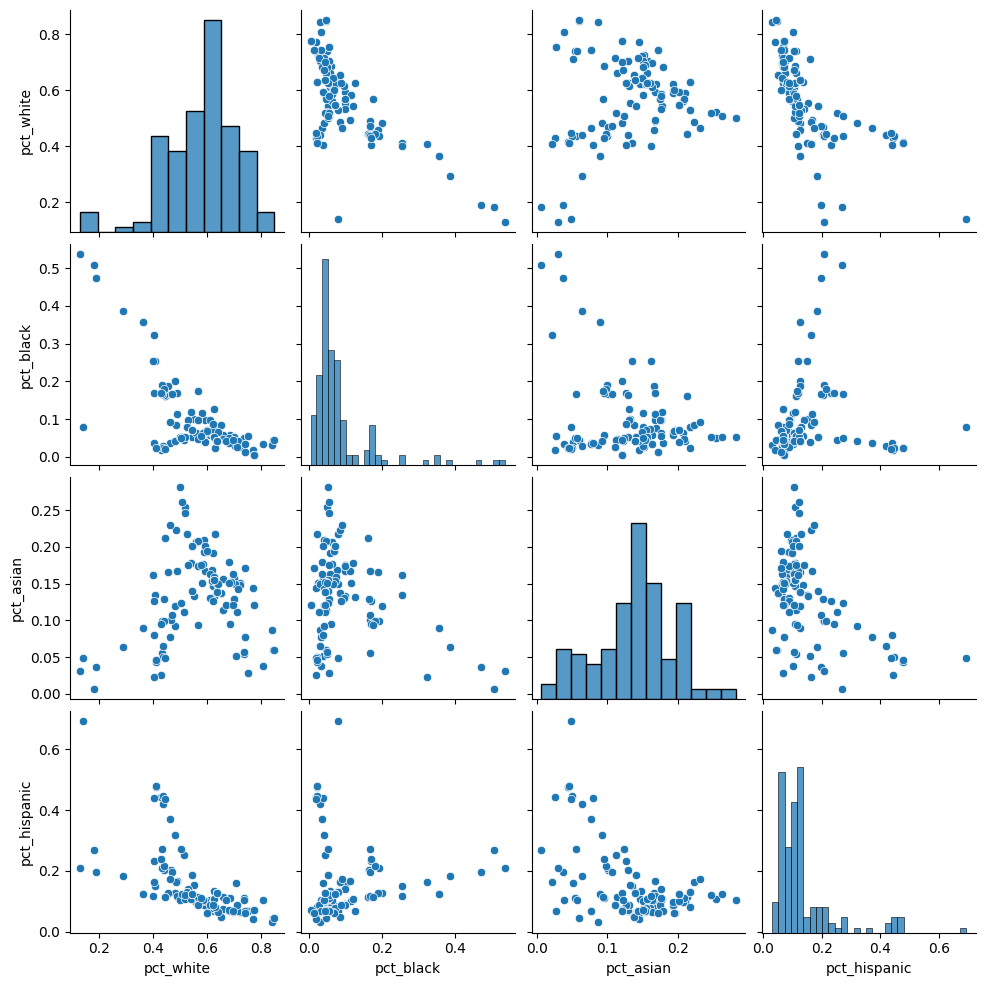

In [27]:
sns.pairplot(
    route_demo[["pct_white","pct_black","pct_asian","pct_hispanic"]],
    kind="scatter"
)
plt.show()


In [28]:
import pandas as pd

# Load the parquet file
arrival = pd.read_parquet("drive/MyDrive/MBTA_Bus_Arrival_Departure_Times_2024.parquet")

# Quick look at the data
print(arrival.columns)
print(arrival.head())
print(arrival.dtypes)


Index(['service_date', 'route_id', 'direction_id', 'half_trip_id', 'stop_id',
       'time_point_id', 'time_point_order', 'point_type', 'standard_type',
       'scheduled', 'actual', 'scheduled_headway', 'headway'],
      dtype='object')
  service_date route_id direction_id  half_trip_id  stop_id time_point_id  \
0   2024-01-01       01      Inbound    61824022.0      110         hhgat   
1   2024-01-01       01      Inbound    61824022.0       67         maput   
2   2024-01-01       01      Inbound    61824022.0       72         cntsq   
3   2024-01-01       01      Inbound    61824022.0       75           mit   
4   2024-01-01       01      Inbound    61824022.0       79         hynes   

   time_point_order  point_type standard_type             scheduled  \
0                 1  Startpoint      Schedule  1900-01-01T06:05:00Z   
1                 2    Midpoint      Schedule  1900-01-01T06:09:00Z   
2                 3    Midpoint      Schedule  1900-01-01T06:12:00Z   
3              

In [29]:
# Convert to datetime if needed
arrival['scheduled'] = pd.to_datetime(arrival['scheduled'])
arrival['actual'] = pd.to_datetime(arrival['actual'])

# Compute lateness in minutes
arrival['lateness'] = (arrival['actual'] - arrival['scheduled']).dt.total_seconds() / 60

# Clip negative lateness to 0 if you only care about being late
arrival['lateness'] = arrival['lateness'].clip(lower=0)

Average lateness per stop and route

In [30]:
avg_lateness = arrival.groupby(['route_id', 'stop_id']).agg({
    'lateness': 'mean',
    'scheduled_headway': 'mean'  # optional operational feature
}).reset_index()


/tmp/ipython-input-400907245.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_lateness = arrival.groupby(['route_id', 'stop_id']).agg({


Merge with stop demographics

In [31]:
avg_lateness['stop_id'] = avg_lateness['stop_id'].astype(str)
stops_with_tract['stop_id'] = stops_with_tract['stop_id'].astype(str)

lateness_demo = avg_lateness.merge(
    stops_with_tract[['stop_id', 'pct_white', 'pct_black', 'pct_asian', 'pct_hispanic']],
    on='stop_id',
    how='left'
)
lateness_demo = lateness_demo.dropna(
    subset=['pct_white', 'pct_black', 'pct_asian', 'pct_hispanic','lateness']
)


In [32]:
# stops_with_tract.value_counts('stop_id')
lateness_demo.head()

,route_id,stop_id,lateness,scheduled_headway,pct_white,pct_black,pct_asian,pct_hispanic
0,01,2,5.184662,775.287403,0.057253,0.314571,0.038598,0.580251
13,01,59,8.624564,793.700574,0.545237,0.172964,0.145556,0.081426
14,01,62,8.932083,793.462834,0.057253,0.314571,0.038598,0.580251
15,01,64,5.391084,781.704581,0.358454,0.154289,0.285284,0.138942
20,01,79,8.279389,793.669493,0.580009,0.054912,0.175032,0.110682


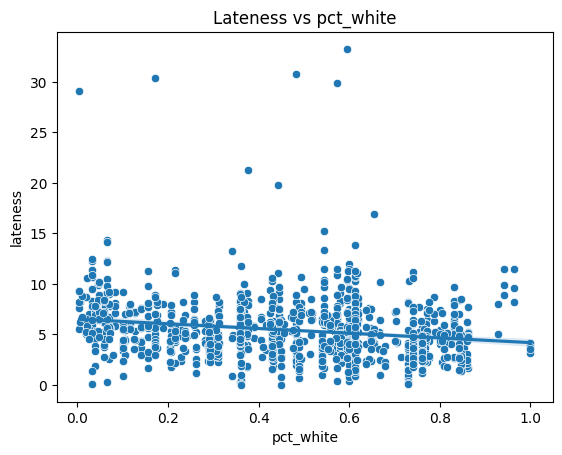

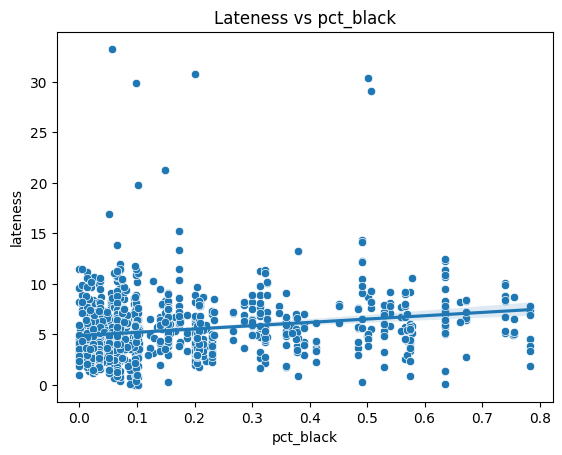

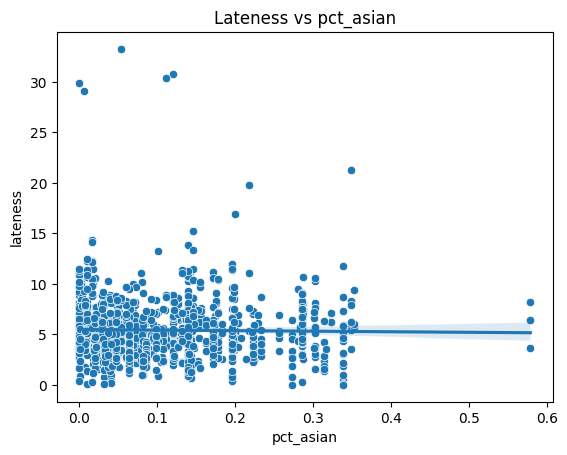

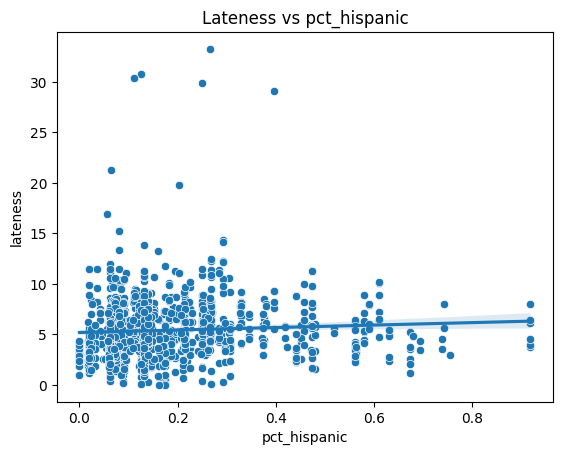

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

demo_cols = ["pct_white", "pct_black", "pct_asian", "pct_hispanic"]

for col in demo_cols:
    sns.scatterplot(data=lateness_demo, x=col, y="lateness")
    sns.regplot(data=lateness_demo, x=col, y="lateness", scatter=False)  # trend line
    plt.title(f"Lateness vs {col}")
    plt.show()


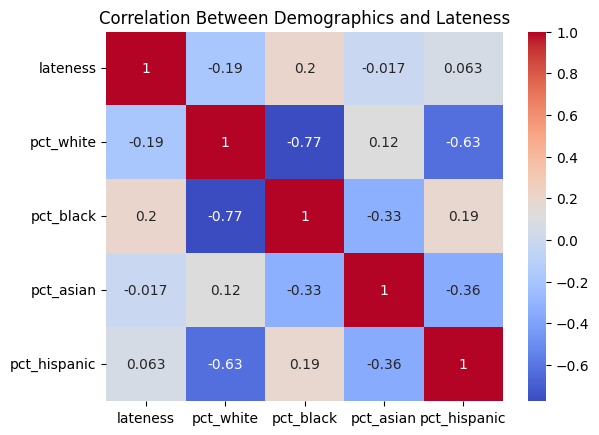

In [34]:
corr = lateness_demo[["lateness","pct_white","pct_black","pct_asian","pct_hispanic"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Between Demographics and Lateness")
plt.show()


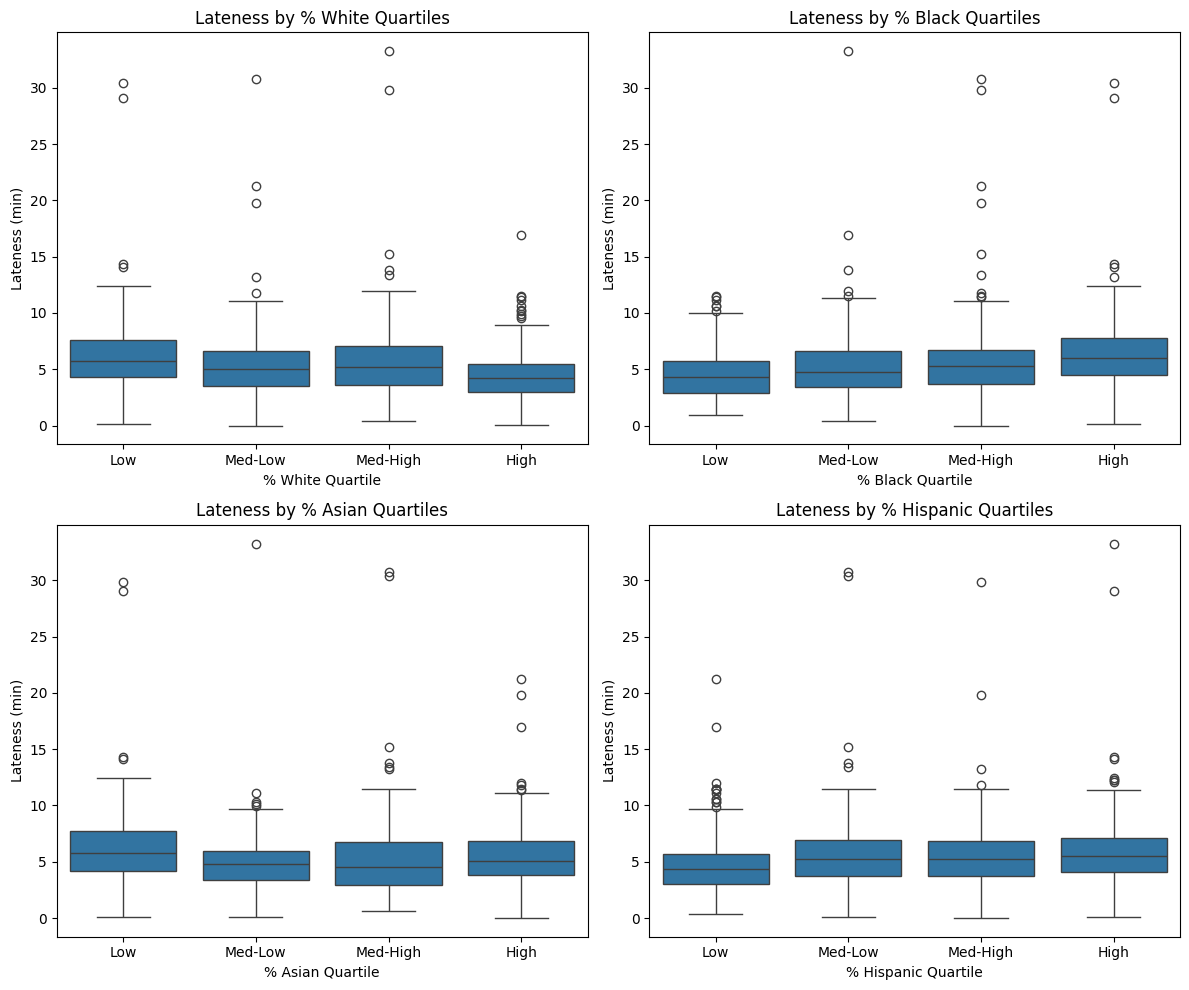

In [35]:
demo_cols = ["pct_white", "pct_black", "pct_asian", "pct_hispanic"]
labels = ["White", "Black", "Asian", "Hispanic"]

# Create quartile bins for each race
for col in demo_cols:
    lateness_demo[col + "_bin"] = pd.qcut(lateness_demo[col], q=4,
                                          labels=["Low","Med-Low","Med-High","High"])

# 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, col, label in zip(axes.flatten(), demo_cols, labels):
    sns.boxplot(
        data=lateness_demo,
        x=col + "_bin",
        y="lateness",
        ax=ax
    )
    ax.set_title(f"Lateness by % {label} Quartiles")
    ax.set_xlabel(f"% {label} Quartile")
    ax.set_ylabel("Lateness (min)")

plt.tight_layout()
plt.show()

In [36]:
route_demo = lateness_demo.groupby("route_id").agg({
    "lateness": "mean",
    "scheduled_headway": "mean",
    "pct_white": "mean",
    "pct_black": "mean",
    "pct_asian": "mean",
    "pct_hispanic": "mean"
}).reset_index()

/tmp/ipython-input-1396369124.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  route_demo = lateness_demo.groupby("route_id").agg({


In [37]:
demo_cols = ["pct_white", "pct_black", "pct_asian", "pct_hispanic"]

for col in demo_cols:
    route_demo[col + "_bin"] = pd.qcut(
        route_demo[col],
        q=4,
        labels=["Low", "Med-Low", "Med-High", "High"]
    )


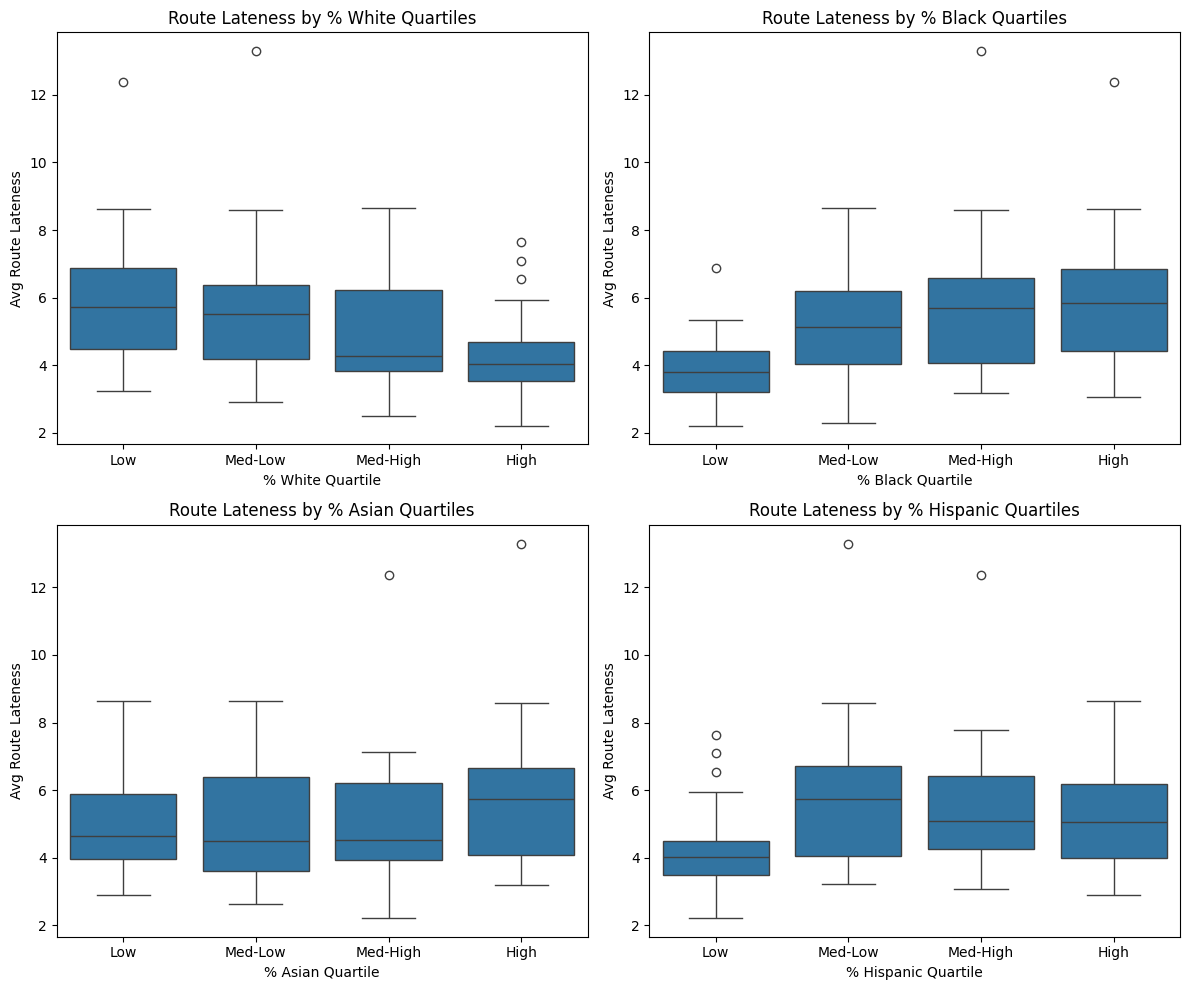

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["White", "Black", "Asian", "Hispanic"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, col, label in zip(axes.flatten(), demo_cols, labels):
    sns.boxplot(
        data=route_demo,
        x=col + "_bin",
        y="lateness",
        ax=ax
    )
    ax.set_title(f"Route Lateness by % {label} Quartiles")
    ax.set_xlabel(f"% {label} Quartile")
    ax.set_ylabel("Avg Route Lateness")

plt.tight_layout()
plt.show()


Compute Non-white percentage

In [39]:
lateness_demo["pct_nonwhite"] = 1 - lateness_demo["pct_white"]


Aggregate to Route-Level

In [40]:
route_equity = lateness_demo.groupby("route_id").agg({
    "lateness": "mean",
    "pct_white": "mean",
    "pct_nonwhite": "mean"
}).reset_index()

/tmp/ipython-input-1225703097.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  route_equity = lateness_demo.groupby("route_id").agg({


Classify Routes: “Majority White” vs. “Majority Non-White”

In [41]:
route_equity["race_group"] = route_equity["pct_white"].apply(
    lambda x: "Majority White" if x > 0.5 else "Majority Non-White"
)

Compare Lateness Between These Two Groups

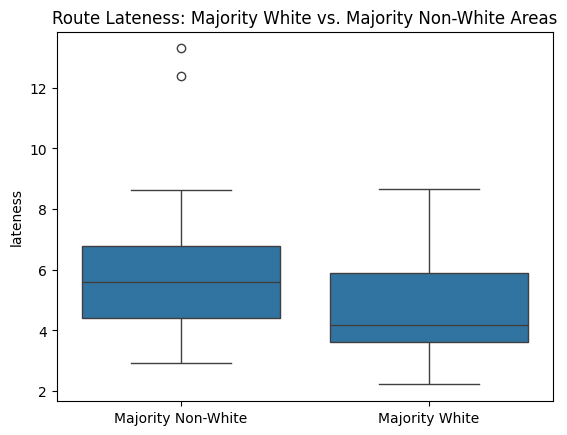

In [42]:
sns.boxplot(data=route_equity, x="race_group", y="lateness")
plt.title("Route Lateness: Majority White vs. Majority Non-White Areas")
plt.xlabel("")
plt.show()

Rank which routes serve minorities the most

In [43]:
routes_most_nonwhite = route_equity.sort_values("pct_nonwhite", ascending=False)
routes_most_nonwhite.head(10)

,route_id,lateness,pct_white,pct_nonwhite,race_group
57,245,7.380987,0.039096,0.960904,Majority Non-White
60,29,8.633963,0.119085,0.880915,Majority Non-White
88,44,7.109206,0.182593,0.817407,Majority Non-White
51,23,6.945541,0.186996,0.813004,Majority Non-White
64,33,4.406507,0.196811,0.803189,Majority Non-White
59,28,7.773622,0.197550,0.802450,Majority Non-White
55,24,6.787711,0.216357,0.783643,Majority Non-White
62,31,4.810580,0.216753,0.783247,Majority Non-White
58,26,3.577079,0.234510,0.765490,Majority Non-White
91,45,12.378683,0.275973,0.724027,Majority Non-White


Which routes most affect minorities

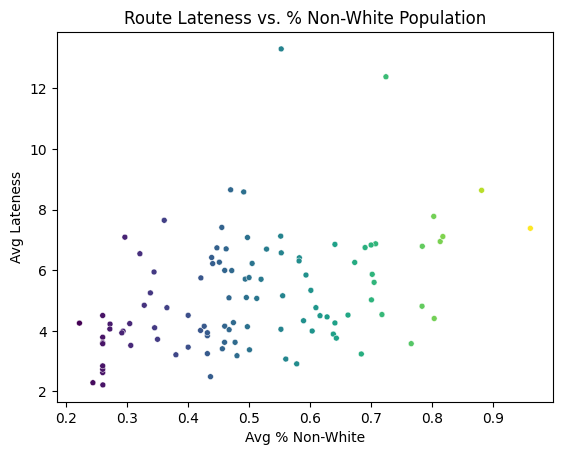

In [44]:
sns.scatterplot(
    data=route_equity,
    x="pct_nonwhite",
    y="lateness",
    hue="pct_nonwhite",
    palette="viridis",
    size=3,
    legend=False
)
plt.title("Route Lateness vs. % Non-White Population")
plt.xlabel("Avg % Non-White")
plt.ylabel("Avg Lateness")
plt.show()


Top 15 routes serving minority areas:

In [45]:
routes_most_nonwhite[["route_id","pct_nonwhite","lateness"]].head(15)

,route_id,pct_nonwhite,lateness
57,245,0.960904,7.380987
60,29,0.880915,8.633963
88,44,0.817407,7.109206
51,23,0.813004,6.945541
64,33,0.803189,4.406507
59,28,0.802450,7.773622
55,24,0.783643,6.787711
62,31,0.783247,4.810580
58,26,0.765490,3.577079
91,45,0.724027,12.378683


Top routes with high lateness and high non-white population:

In [46]:
route_equity.assign(
    score = route_equity["pct_nonwhite"] * route_equity["lateness"]
).sort_values("score", ascending=False).head(15)

,route_id,lateness,pct_white,pct_nonwhite,race_group,score
91,45,12.378683,0.275973,0.724027,Majority Non-White,8.962498
60,29,8.633963,0.119085,0.880915,Majority Non-White,7.605791
111,600,13.296432,0.447767,0.552233,Majority Non-White,7.342725
57,245,7.380987,0.039096,0.960904,Majority Non-White,7.092423
59,28,7.773622,0.197550,0.802450,Majority Non-White,6.237940
88,44,7.109206,0.182593,0.817407,Majority Non-White,5.811115
51,23,6.945541,0.186996,0.813004,Majority Non-White,5.646755
55,24,6.787711,0.216357,0.783643,Majority Non-White,5.319142
17,114,6.869592,0.292936,0.707064,Majority Non-White,4.857241
30,17,6.830264,0.300314,0.699686,Majority Non-White,4.779037


Compare lateness ranking and non-white ranking together:

In [47]:
route_equity.sort_values("pct_nonwhite", ascending=False)[["route_id","lateness","pct_nonwhite"]].head(10)


,route_id,lateness,pct_nonwhite
57,245,7.380987,0.960904
60,29,8.633963,0.880915
88,44,7.109206,0.817407
51,23,6.945541,0.813004
64,33,4.406507,0.803189
59,28,7.773622,0.802450
55,24,6.787711,0.783643
62,31,4.810580,0.783247
58,26,3.577079,0.765490
91,45,12.378683,0.724027


In [48]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# tracts is your census data GeoDataFrame
boston_tracts["group"] = np.where(
    boston_tracts["pct_white"] >= 0.5,
    "Majority White",
    "Majority Non-White"
)


In [49]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString


shapes = pd.read_csv("drive/MyDrive/MBTA_GTFS/shapes.txt")
trips = pd.read_csv("drive/MyDrive/MBTA_GTFS/trips.txt")

# Make a LineString for each shape_id
shape_lines = (
    shapes.sort_values(["shape_id", "shape_pt_sequence"])
          .groupby("shape_id")
          .apply(lambda group: LineString(zip(group["shape_pt_lon"], group["shape_pt_lat"])))

        .reset_index(name="geometry")
)

shape_route_map = trips[["shape_id", "route_id"]].drop_duplicates()
routes_gdf = gpd.GeoDataFrame(shape_lines, geometry="geometry", crs="EPSG:4326")

routes_gdf = routes_gdf.merge(shape_route_map, on="shape_id", how="left")


print(routes_gdf.columns)



routes_gdf = routes_gdf.merge(
    lateness_demo,
    on="route_id",
    how="left"
)

shape_lines = (
    shapes.sort_values(["shape_id", "shape_pt_sequence"])
          .groupby("shape_id")
          .apply(lambda group: LineString(zip(group["shape_pt_lon"], group["shape_pt_lat"])))
          .reset_index(name="geometry")
)



/tmp/ipython-input-1405828624.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: LineString(zip(group["shape_pt_lon"], group["shape_pt_lat"])))


Index(['shape_id', 'geometry', 'route_id'], dtype='object')


/tmp/ipython-input-1405828624.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: LineString(zip(group["shape_pt_lon"], group["shape_pt_lat"])))


Clip routes to Boston bounds

In [50]:
from shapely.geometry import box

# Create a bounding box for Boston tracts
minx, miny, maxx, maxy = boston_tracts.total_bounds
boston_bbox = box(minx, miny, maxx, maxy)

# Clip routes to Boston
routes_gdf = routes_gdf.clip(boston_bbox)

routes_gdf = routes_gdf[routes_gdf.intersects(boston_bbox)]

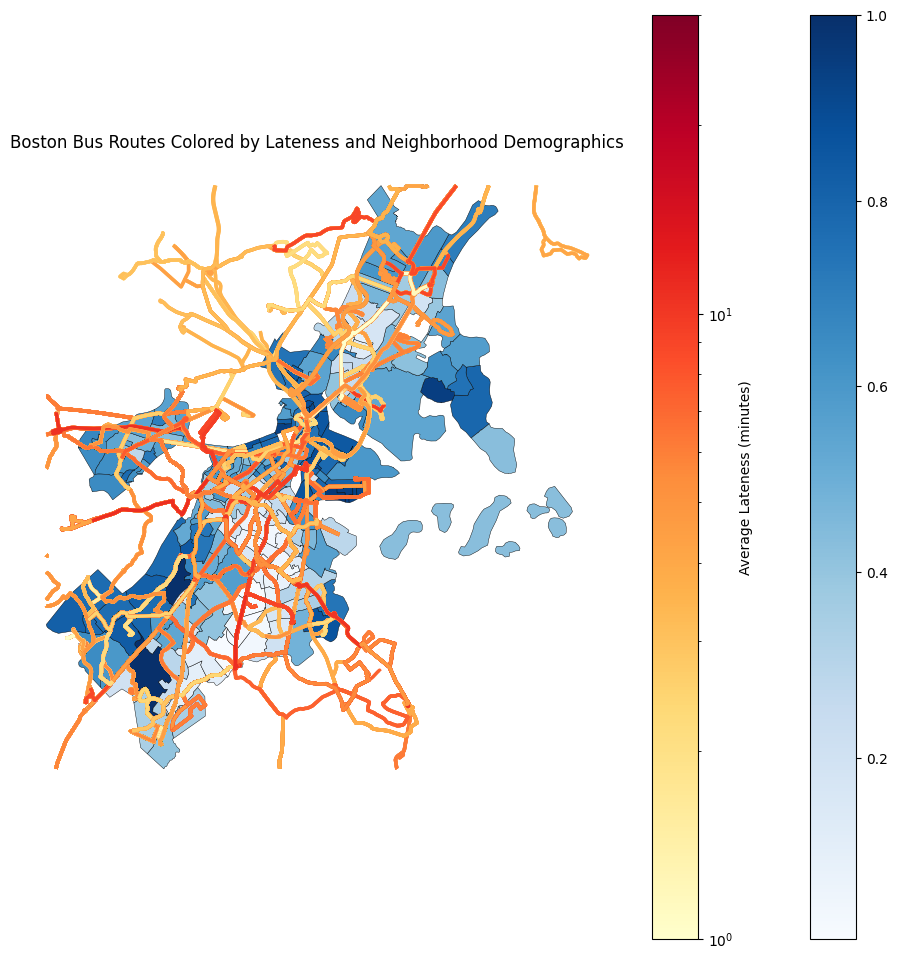

In [51]:
import matplotlib.colors as colors
# 1. Ensure routes CRS matches tracts CRS
routes_gdf = routes_gdf.set_crs("EPSG:4326")  # if not already
routes_gdf = routes_gdf.to_crs(boston_tracts.crs)

# 2. Plot
fig, ax = plt.subplots(figsize=(12, 12))

boston_tracts.plot(
        column="pct_white",
        cmap="Blues",      # Red → Blue colormap
        legend=True,
        ax=ax,
        edgecolor='black', # optional: outlines tracts
        linewidth=0.3
    )

routes_gdf.plot(
    column="lateness",
    ax=ax,
    linewidth=2.5,
    cmap="YlOrRd",
    legend=True,
    norm=colors.LogNorm(vmin=1, vmax=30),
    legend_kwds={"label": "Average Lateness (minutes)"}
)

plt.title("Boston Bus Routes Colored by Lateness and Neighborhood Demographics")
plt.axis("off")
plt.show()


In [52]:

stops_gdf_lateness = stops_gdf.merge(lateness_demo, on="stop_id", how="left")


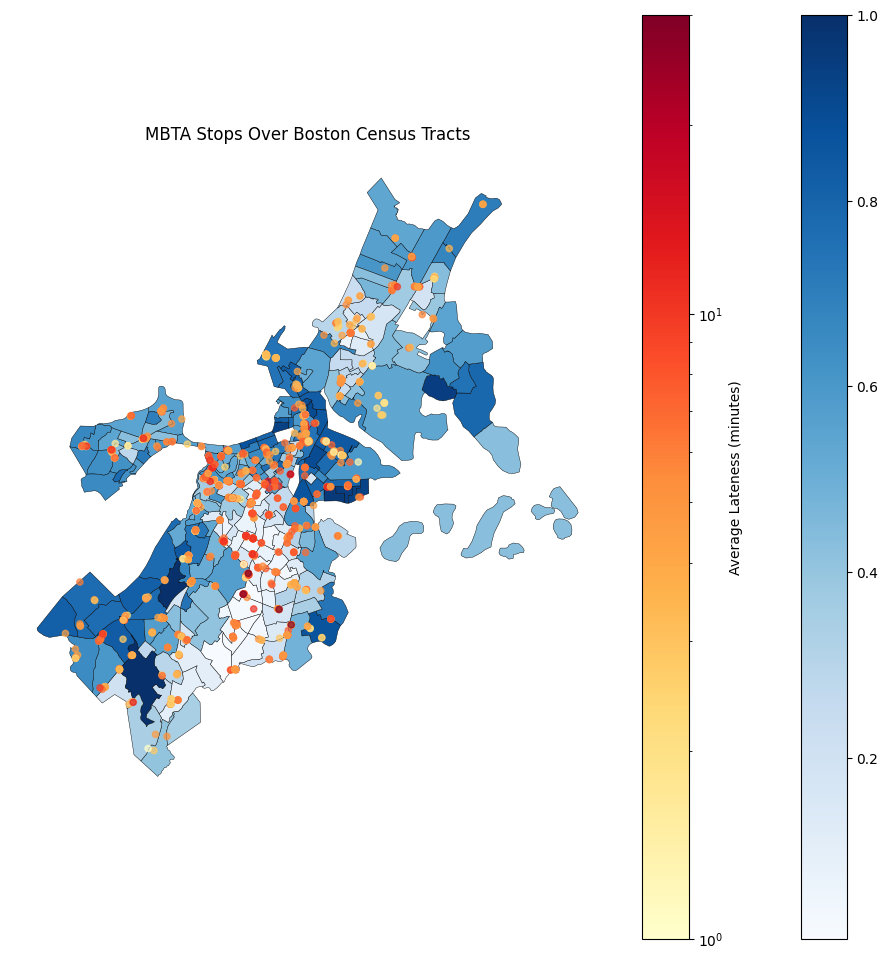

In [53]:
# Background: Boston tracts
fig, ax = plt.subplots(figsize=(12,12))
boston_tracts.plot(
    column="pct_white",
    cmap="Blues",       # Light → Dark Blue for demographics
    legend=True,
    ax=ax,
    edgecolor='black',
    linewidth=0.3
)


stops_gdf_lateness.plot(
    ax=ax,
    column="lateness",
    cmap="YlOrRd",
    markersize=20,
    alpha=0.7,
    legend=True,
    norm=colors.LogNorm(vmin=1, vmax=30),
    legend_kwds={"label": "Average Lateness (minutes)"}
)

plt.title("MBTA Stops Over Boston Census Tracts")
plt.axis("off")
plt.show()


## Clustering

In [54]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

In [55]:
import numpy as np
import pandas as pd

# 1) Get a single centroid point per route from routes_gdf
# (routes_gdf already has geometry + route_id in your notebook)
routes_gdf["centroid"] = routes_gdf.geometry.centroid
routes_gdf["route_lon"] = routes_gdf["centroid"].x
routes_gdf["route_lat"] = routes_gdf["centroid"].y

route_geo = (
    routes_gdf[["route_id", "route_lat", "route_lon"]]
    .drop_duplicates("route_id")
)

# 2) Combine equity (demographics + lateness) with location
route_feat_all = route_equity.merge(route_geo, on="route_id", how="left")

route_feat_all.head()

/tmp/ipython-input-569658494.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  routes_gdf["centroid"] = routes_gdf.geometry.centroid


,route_id,lateness,pct_white,pct_nonwhite,race_group,route_lat,route_lon
0,01,7.122365,0.448587,0.551413,Majority Non-White,NaN,NaN
1,04,7.088457,0.704144,0.295856,Majority White,NaN,NaN
2,07,4.222217,0.728481,0.271519,Majority White,NaN,NaN
3,08,6.222936,0.495440,0.504560,Majority Non-White,NaN,NaN
4,09,5.940358,0.656315,0.343685,Majority White,NaN,NaN


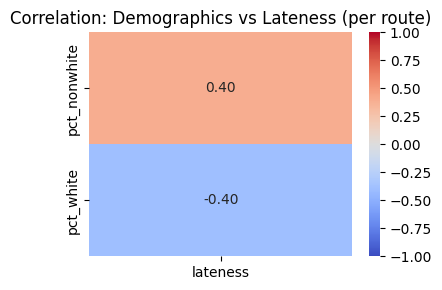

,lateness
pct_nonwhite,0.398267
pct_white,-0.398267


In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

demo_cols = ["pct_nonwhite", "pct_white"]
service_cols = ["lateness"]

feat_cols = demo_cols + service_cols

route_feat = route_feat_all.dropna(subset=feat_cols).copy()

corr_all = route_feat[feat_cols].corr()

corr_demo_service = corr_all.loc[demo_cols, service_cols]

plt.figure(figsize=(4, 3))
sns.heatmap(
    corr_demo_service,
    annot=True,
    fmt=".2f",
    vmin=-1, vmax=1,
    cmap="coolwarm"
)
plt.title("Correlation: Demographics vs Lateness (per route)")
plt.tight_layout()
plt.show()

corr_demo_service

In [57]:
route_feat.sort_values(
    by=["pct_nonwhite", "lateness"],
    ascending=[False, False]
)[["route_id", "pct_nonwhite", "lateness"]].head(10)

,route_id,pct_nonwhite,lateness
57,245,0.960904,7.380987
60,29,0.880915,8.633963
88,44,0.817407,7.109206
51,23,0.813004,6.945541
64,33,0.803189,4.406507
59,28,0.802450,7.773622
55,24,0.783643,6.787711
62,31,0.783247,4.810580
58,26,0.765490,3.577079
91,45,0.724027,12.378683


In [58]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import numpy as np

feat_cols = demo_cols + service_cols

X = route_feat[feat_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

corr_routes = np.corrcoef(X_scaled)

dist_routes = 1 - corr_routes

dist_condensed = squareform(dist_routes, checks=False)

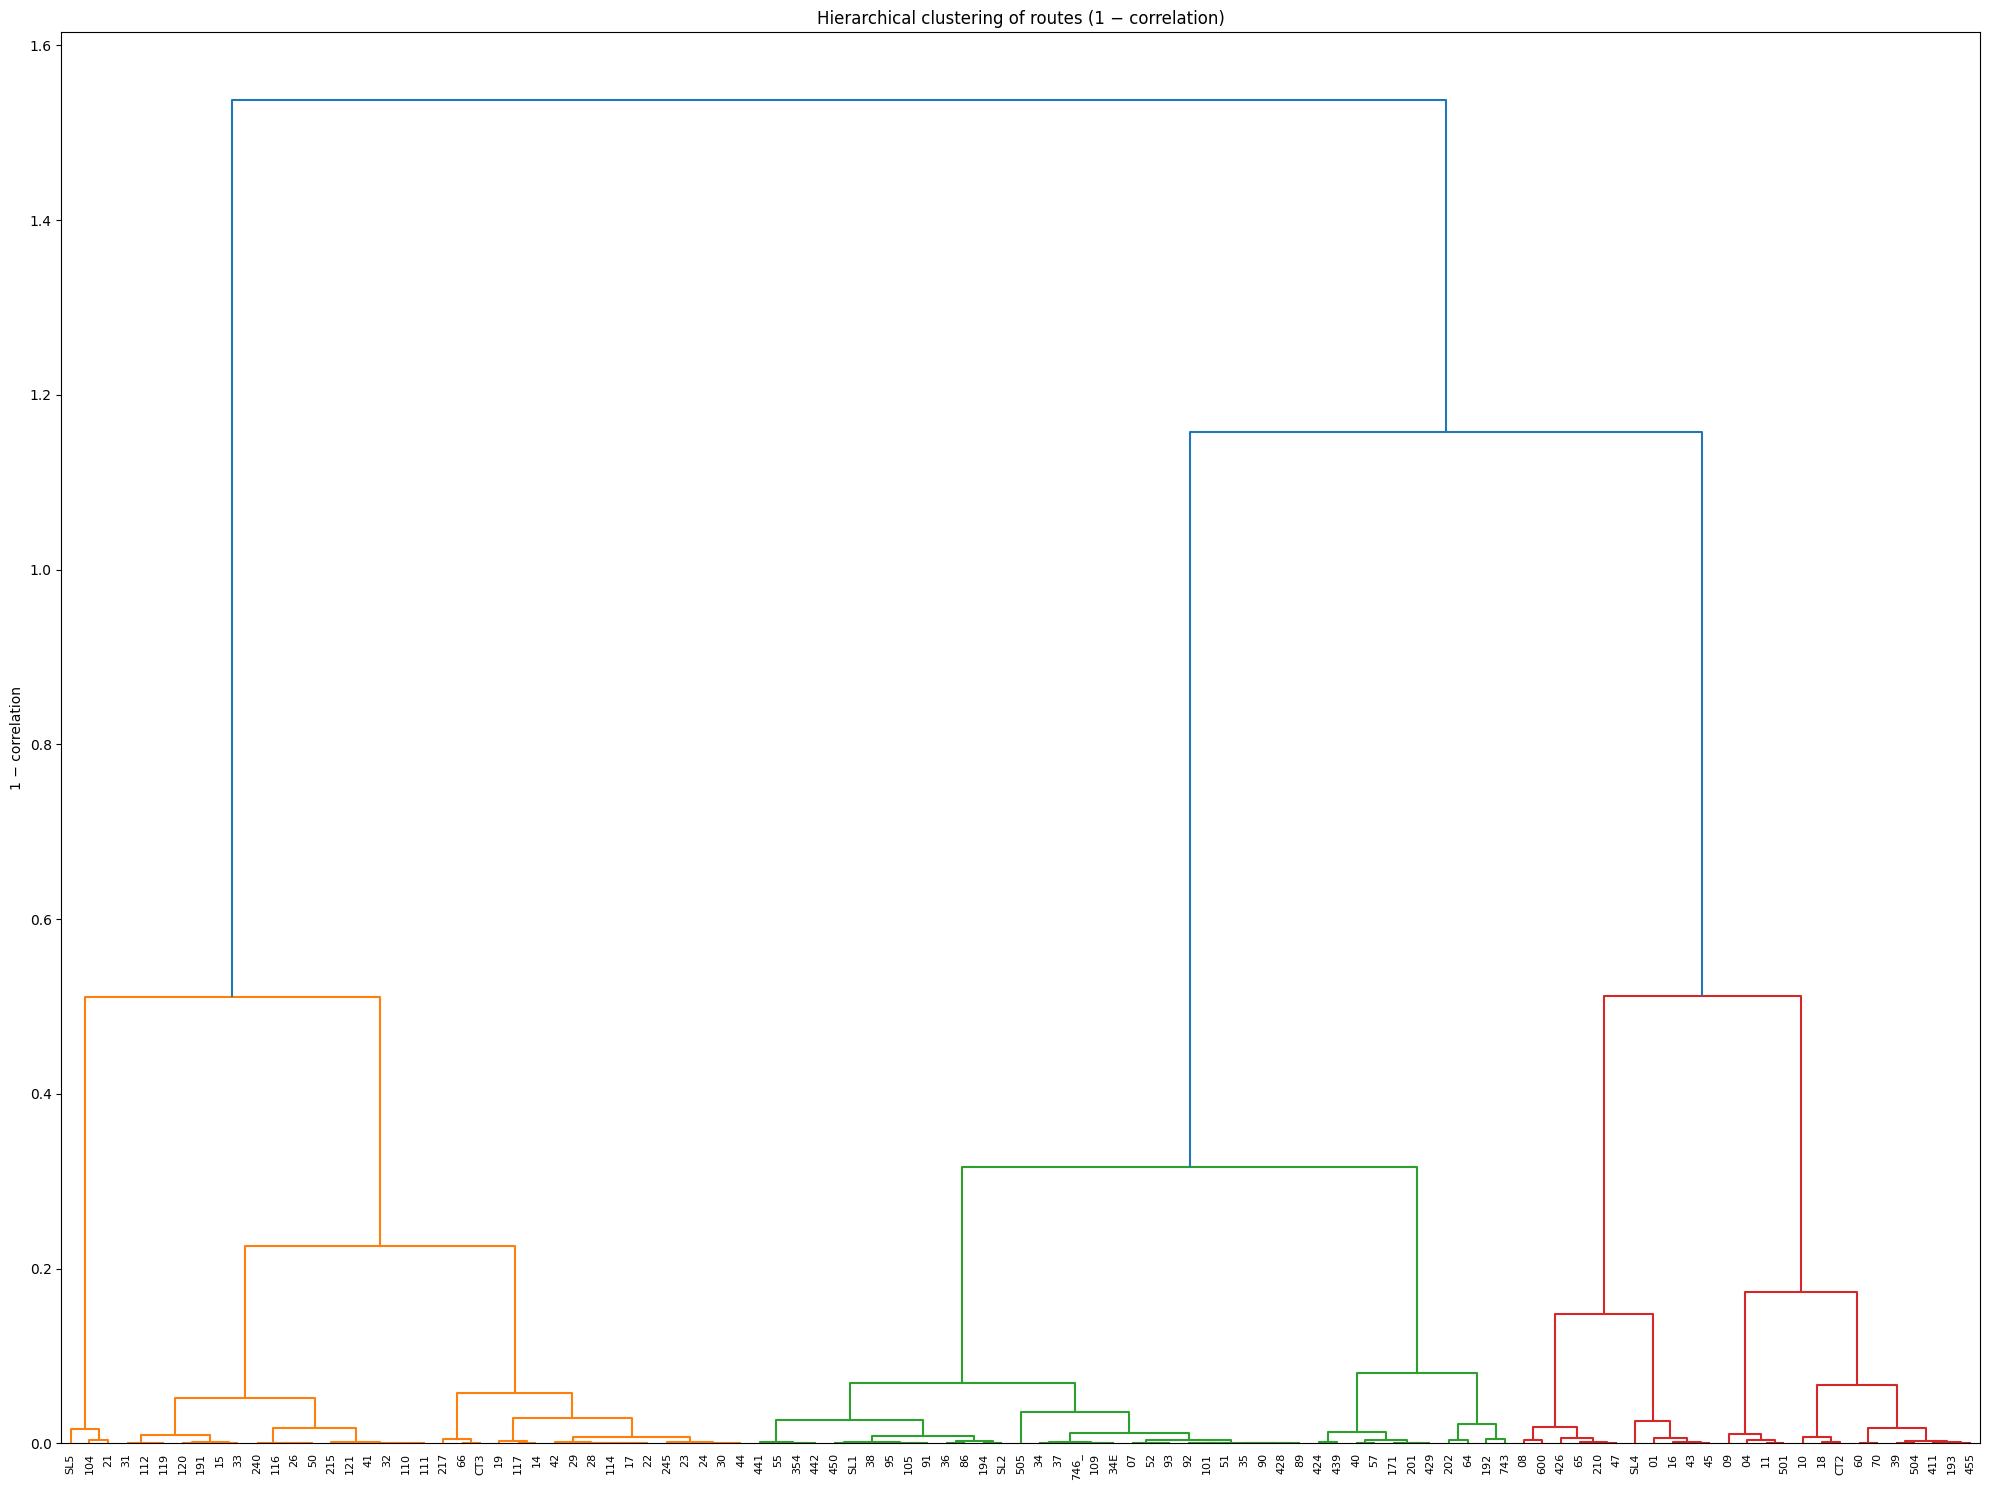

In [59]:
plt.figure(figsize=(20, 15))
Z = linkage(dist_condensed, method="average")

dendrogram(
    Z,
    labels=route_feat["route_id"].astype(str).values,
    leaf_rotation=90,
    leaf_font_size=8,
)
plt.title("Hierarchical clustering of routes (1 − correlation)")
plt.ylabel("1 − correlation")
plt.tight_layout()
plt.show()

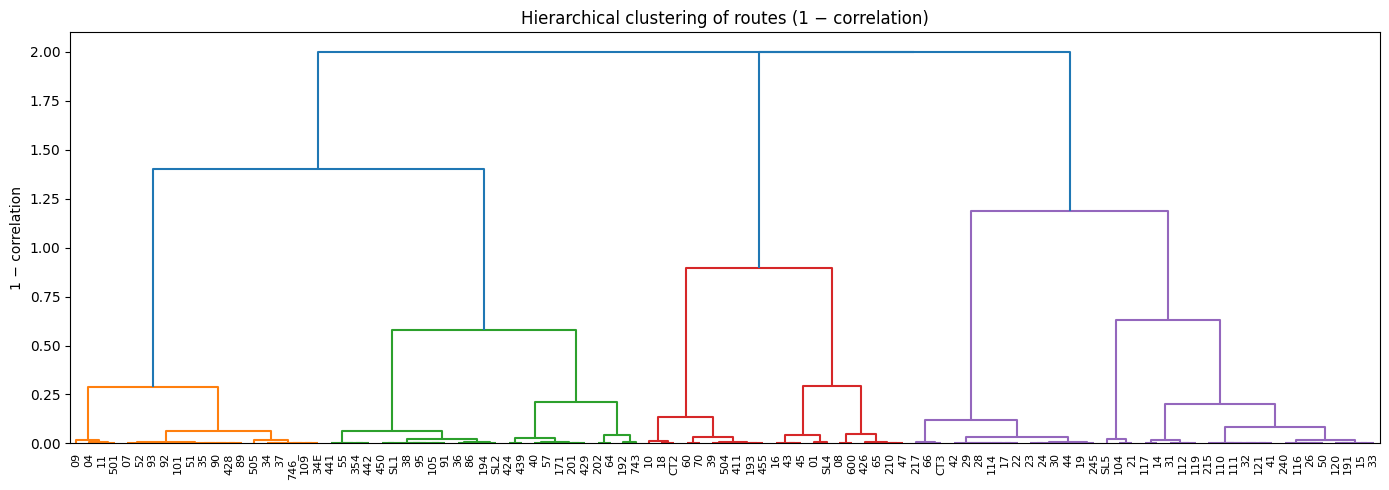

In [60]:
plt.figure(figsize=(14, 5))
Z = linkage(dist_condensed, method="complete")

dendrogram(
    Z,
    labels=route_feat["route_id"].astype(str).values,
    leaf_rotation=90,
    leaf_font_size=8,
)
plt.title("Hierarchical clustering of routes (1 − correlation)")
plt.ylabel("1 − correlation")
plt.tight_layout()
plt.show()

k = 2, silhouette = 0.651
k = 3, silhouette = 0.776
k = 4, silhouette = 0.658
k = 5, silhouette = 0.579
k = 6, silhouette = 0.617
k = 7, silhouette = 0.621
k = 8, silhouette = 0.634
k = 9, silhouette = 0.645
k = 10, silhouette = 0.730


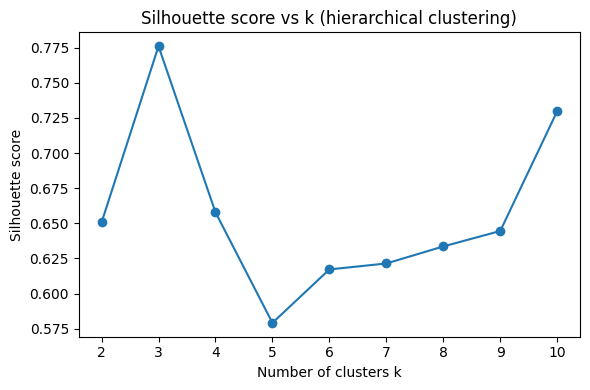

Best k by silhouette: 3


In [61]:
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

k_values = range(2, 11)   # try 2 to 10 clusters
sil_scores = []

for k in k_values:
    labels = fcluster(Z, k, criterion="maxclust")
    # use precomputed distance matrix (1 - correlation)
    score = silhouette_score(dist_routes, labels, metric="precomputed")
    sil_scores.append(score)
    print(f"k = {k}, silhouette = {score:.3f}")

# plot k vs silhouette score (elbow-style visual)
plt.figure(figsize=(6, 4))
plt.plot(k_values, sil_scores, marker="o")
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette score")
plt.title("Silhouette score vs k (hierarchical clustering)")
plt.tight_layout()
plt.show()

# pick the best k
best_k = k_values[int(np.argmax(sil_scores))]
print("Best k by silhouette:", best_k)

In [62]:
n_clusters = best_k

route_feat["cluster_corr"] = fcluster(Z, n_clusters, criterion="maxclust")
route_feat["cluster_corr"].value_counts().sort_index()

,count
cluster_corr,
1,45
2,21
3,37


In [63]:
cluster_summary = (
    route_feat
    .groupby("cluster_corr")[feat_cols]
    .mean()
    .round(3)
)

cluster_sizes = route_feat.groupby("cluster_corr").size().rename("n_routes")
cluster_summary = cluster_summary.join(cluster_sizes)

cluster_summary

,pct_nonwhite,pct_white,lateness,n_routes
cluster_corr,,,,
1,0.364,0.636,4.027,45
2,0.494,0.506,7.292,21
3,0.678,0.322,5.347,37


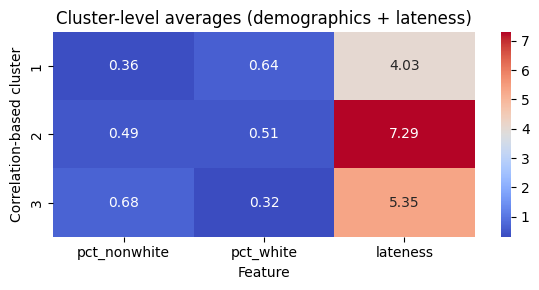

In [64]:
plt.figure(figsize=(6, 3))
sns.heatmap(
    cluster_summary[feat_cols],
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
)
plt.title("Cluster-level averages (demographics + lateness)")
plt.xlabel("Feature")
plt.ylabel("Correlation-based cluster")
plt.tight_layout()
plt.show()

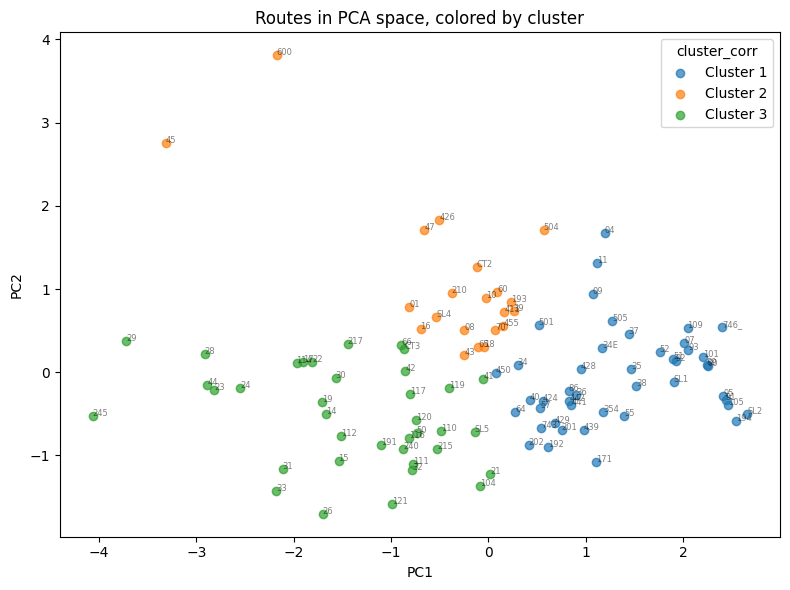

In [65]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plot_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "cluster_corr": route_feat["cluster_corr"].astype(str),
    "route_id": route_feat["route_id"].astype(str),
})

plt.figure(figsize=(8, 6))
for c in sorted(plot_df["cluster_corr"].unique(), key=int):
    subset = plot_df[plot_df["cluster_corr"] == c]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"Cluster {c}", alpha=0.7)

for _, row in plot_df.iterrows():
    plt.text(row["PC1"], row["PC2"], row["route_id"], fontsize=6, alpha=0.5)

plt.title("Routes in PCA space, colored by cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="cluster_corr")
plt.tight_layout()
plt.show()

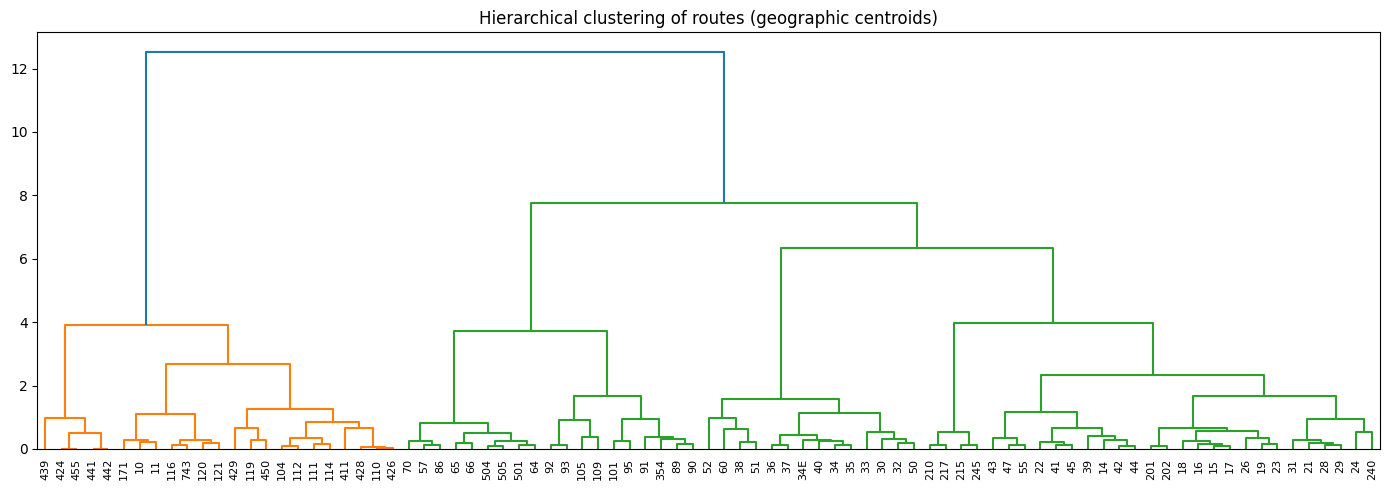

cluster_geo,1,2,3,4
cluster_corr,,,,
1,10,15,9,3
2,4,3,1,7
3,9,1,4,19


In [66]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler

loc_cols = ["route_lat", "route_lon"]

route_geo_feat = route_feat.dropna(subset=loc_cols).copy()

X_loc = route_geo_feat[loc_cols].values
X_loc_scaled = StandardScaler().fit_transform(X_loc)

Z_geo = linkage(X_loc_scaled, method="ward")

plt.figure(figsize=(14, 5))
dendrogram(
    Z_geo,
    labels=route_geo_feat["route_id"].astype(str).values,
    leaf_rotation=90,
    leaf_font_size=8,
)
plt.title("Hierarchical clustering of routes (geographic centroids)")
plt.tight_layout()
plt.show()

n_clusters_geo = 4
route_geo_feat["cluster_geo"] = fcluster(Z_geo, n_clusters_geo, criterion="maxclust")

pd.crosstab(route_geo_feat["cluster_corr"], route_geo_feat["cluster_geo"])

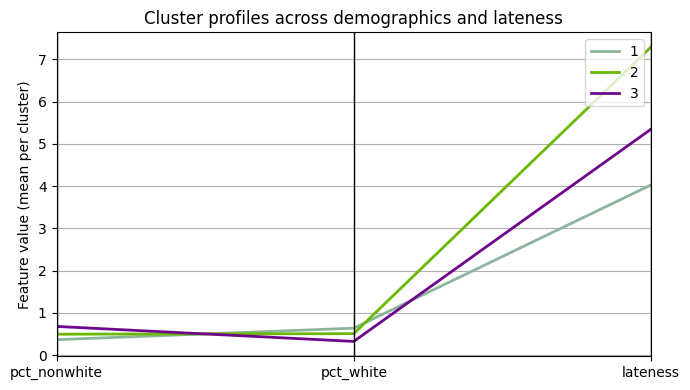

In [67]:
from pandas.plotting import parallel_coordinates

feat_cols = ["pct_nonwhite", "pct_white", "lateness"]

# cluster means as a small table
cluster_means = (
    route_feat
    .groupby("cluster_corr")[feat_cols]
    .mean()
    .reset_index()
)

plt.figure(figsize=(7, 4))
parallel_coordinates(
    cluster_means.rename(columns={"cluster_corr": "cluster"}),
    "cluster",
    cols=feat_cols,
    linewidth=2,
)
plt.title("Cluster profiles across demographics and lateness")
plt.ylabel("Feature value (mean per cluster)")
plt.tight_layout()
plt.show()

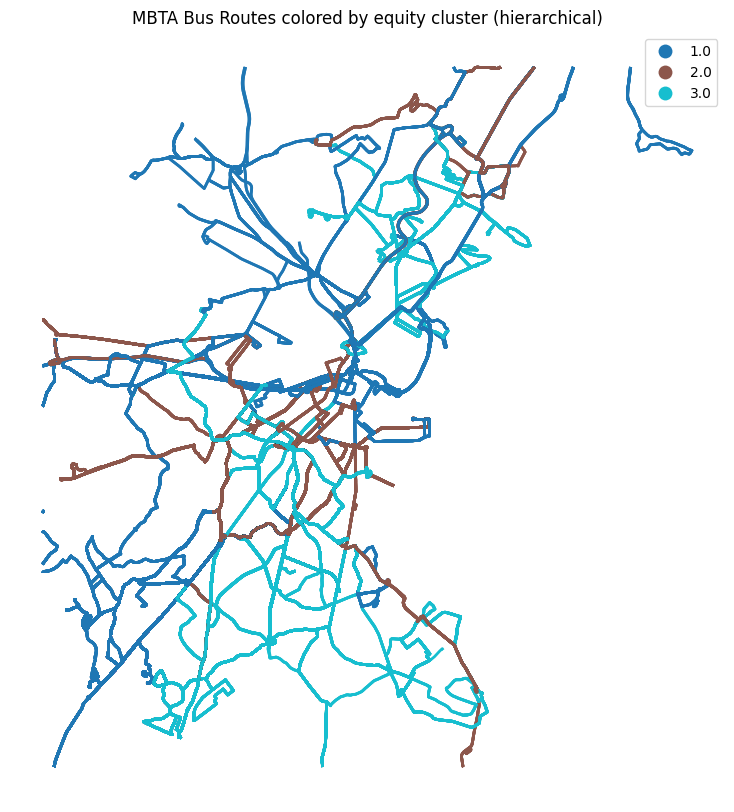

In [68]:
route_feat_all = route_feat_all.merge(
    route_feat[["route_id", "cluster_corr"]],
    on="route_id",
    how="left"
)

routes_gdf_clusters = routes_gdf.merge(
    route_feat_all[["route_id", "cluster_corr"]],
    on="route_id",
    how="left"
)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
routes_gdf_clusters.plot(
    column="cluster_corr",
    categorical=True,
    legend=True,
    linewidth=2,
    ax=ax
)

plt.title("MBTA Bus Routes colored by equity cluster (hierarchical)")
plt.axis("off")
plt.show()